In [1]:
from torch_snippets_local import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import warnings
import configparser
import matplotlib.pyplot as plt
import numpy as np
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load configuration
config = configparser.ConfigParser()
config.read('config.ini')
# Load parameters from config file
#root = '/Users/leonjye/Documents/MachineLearingData'
root = config.get('DEFAULT', 'root_dir')
IMAGE_ROOT = os.path.join(root, 'MNIST')

train_dataset = datasets.MNIST(root=IMAGE_ROOT, train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root=IMAGE_ROOT, train=False, transform=transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [2]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        self.d1 = nn.Linear(x_dim, h_dim1)
        self.d2 = nn.Linear(h_dim1, h_dim2)
        self.d31 = nn.Linear(h_dim2, z_dim)
        self.d32 = nn.Linear(h_dim2, z_dim)
        self.d4 = nn.Linear(z_dim, h_dim2)
        self.d5 = nn.Linear(h_dim2, h_dim1)
        self.d6 = nn.Linear(h_dim1, x_dim)
    def encoder(self, x):
        h = F.relu(self.d1(x))
        h = F.relu(self.d2(h))
        return self.d31(h), self.d32(h)
    def sampling(self, mean, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean)
    def decoder(self, z):
        h = F.relu(self.d4(z))
        h = F.relu(self.d5(h))
        return F.sigmoid(self.d6(h))
    def forward(self, x):
        mean, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mean, log_var)
        return self.decoder(z), mean, log_var


In [3]:
def train_batch(data, model, optimizer, loss_function):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon_batch, data, mean, log_var)
    loss.backward()
    optimizer.step()
    return loss, mse, kld, log_var.mean(), mean.mean()

@torch.no_grad()
def validate_batch(data, model, loss_function):
    model.eval()
    data = data.to(device)
    recon, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon, data, mean, log_var)
    return loss, mse, kld, log_var.mean(), mean.mean()

In [4]:
def loss_function(recon_x, x, mean, log_var):
    RECON = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return RECON + KLD, RECON, KLD

In [5]:
vae = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=50).to(device)
optimizer = optim.AdamW(vae.parameters(), lr=1e-3)

Test Epoch: 1/10 [157/157] Loss: 606.7610 KLD: 128.1609 Recon: 478.6000514

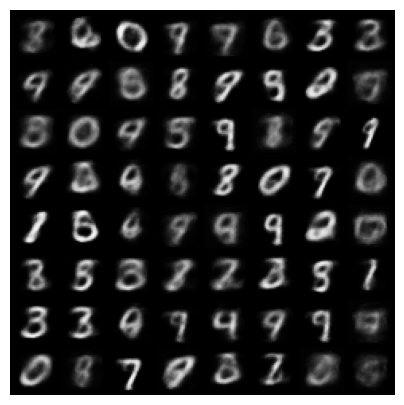

Test Epoch: 2/10 [157/157] Loss: 528.9021 KLD: 149.4654 Recon: 379.4367789

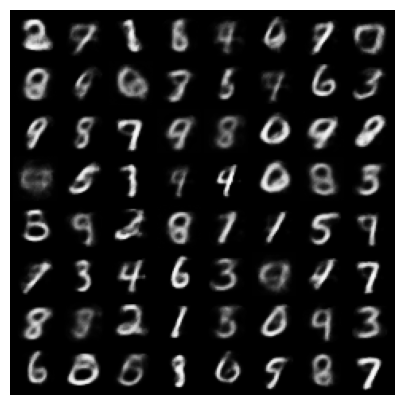

Test Epoch: 3/10 [157/157] Loss: 508.5602 KLD: 153.6062 Recon: 354.9540049

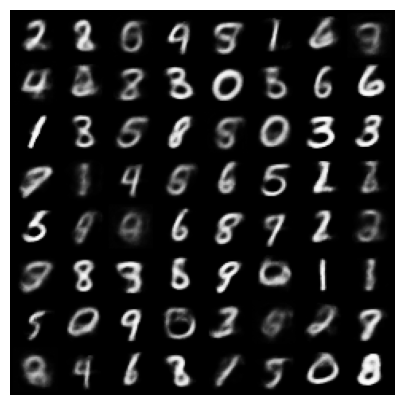

Test Epoch: 4/10 [157/157] Loss: 498.8737 KLD: 161.9678 Recon: 336.9059293

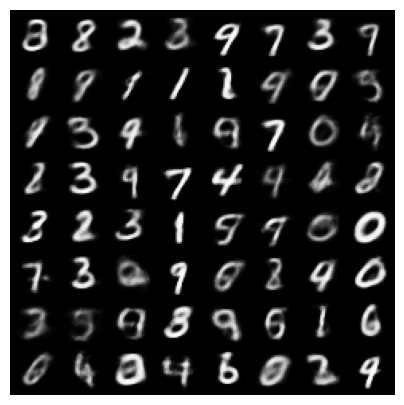

Test Epoch: 5/10 [157/157] Loss: 467.5576 KLD: 160.4573 Recon: 307.1002903

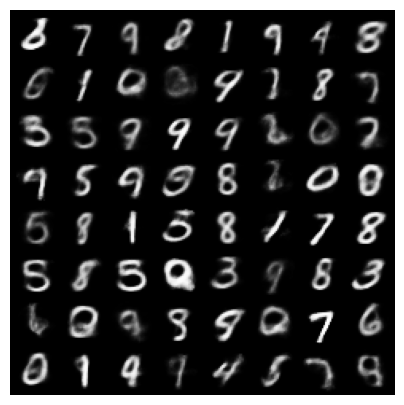

Test Epoch: 6/10 [157/157] Loss: 464.0602 KLD: 164.2509 Recon: 299.8093932

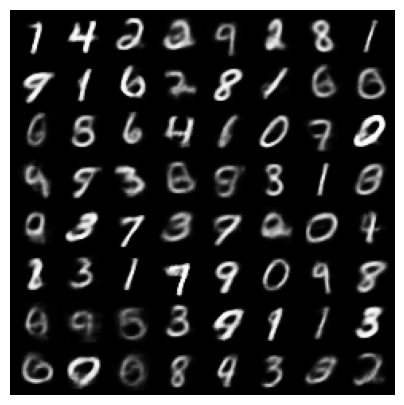

Test Epoch: 7/10 [157/157] Loss: 461.2241 KLD: 165.7310 Recon: 295.4930134

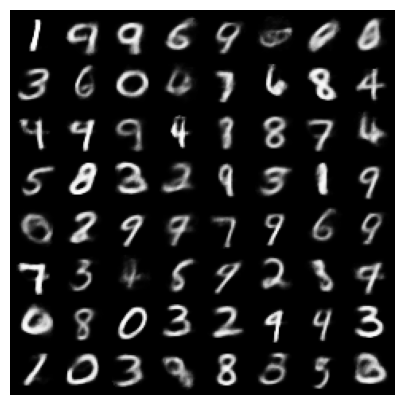

Test Epoch: 8/10 [157/157] Loss: 454.1493 KLD: 164.6675 Recon: 289.4818696

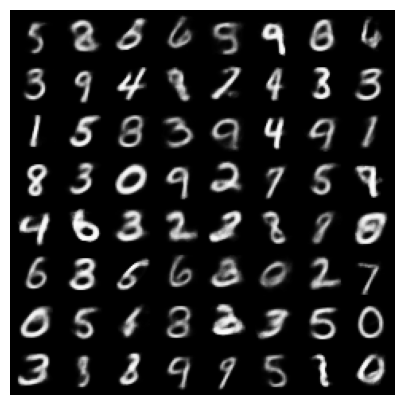

Test Epoch: 9/10 [157/157] Loss: 451.4497 KLD: 167.4036 Recon: 284.0461431

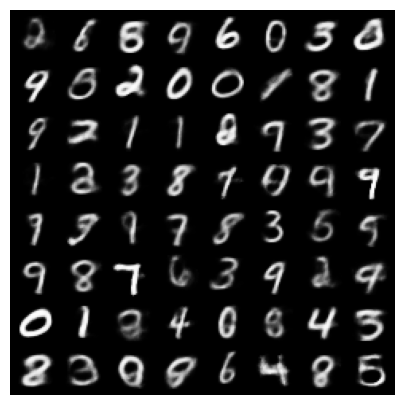

Test Epoch: 10/10 [157/157] Loss: 481.3303 KLD: 166.1129 Recon: 315.2174034

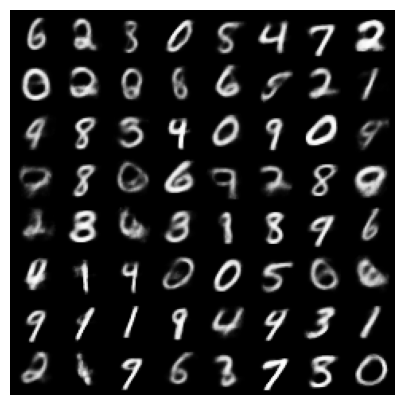

In [6]:
n_epochs = 10
#log = Report(n_epochs)

for epoch in range(n_epochs):
    N = len(train_loader)
    for batch_idx, (data, _) in enumerate(train_loader):
        loss, recon, kld, log_var, mean = train_batch(data, vae, optimizer, loss_function)
        pos = epoch + (1+batch_idx)/N
        print(f'\rTrain Epoch: {epoch+1}/{n_epochs} [{batch_idx+1}/{N}] Loss: {loss.item():.4f} KLD: {kld.item():.4f} Recon: {recon.item():.4f}', end='')
        #log.record(pos, train_loss=loss, train_kld=kld, train_recon=recon, train_log_var=log_var, train_mean=mean, end='\r')
        
    N = len(test_loader)
    for batch_idx, (data, _) in enumerate(test_loader):
        loss, recon, kld, log_var, mean = validate_batch(data, vae, loss_function)
        pos = epoch + (1+batch_idx)/N
        print(f'\rTest Epoch: {epoch+1}/{n_epochs} [{batch_idx+1}/{N}] Loss: {loss.item():.4f} KLD: {kld.item():.4f} Recon: {recon.item():.4f}', end='')
        #log.record(pos, val_loss=loss, val_kld=kld, val_recon=recon, val_log_var=log_var, val_mean=mean, end='\r')
        
    #log.report_avgs(epoch+1)
    with torch.no_grad():
        z = torch.randn(64, 50).to(device)
        sample = vae.decoder(z).to(device)
        images = make_grid(sample.view(64, 1, 28, 28)).permute(1,2,0)
        simple_show(images)

In [7]:
#log.plot_epochs(['train_loss','val_loss'])